In [2]:
#download necessary packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import nltk
import pickle


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.utils import tokenize
from gensim.models import Phrases, Word2Vec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, BatchNormalization, LSTM, SpatialDropout1D, GRU, Bidirectional, Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [3]:
path_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_data.csv'
path_labels = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_results.csv'
path_test_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\test_data.csv'

In [27]:
data_df = pd.read_csv(path_data)
label_df = pd.read_csv(path_labels)
test_df = pd.read_csv(path_test_data)

In [28]:
df = pd.merge(data_df, label_df, on='id')

In [29]:
df

,id,text,target
0,0,Anyway Im getting of for a while,positive
1,1,"My red, Apache isn't feelin too well this morn...",negative
2,2,@danyelljoy you should be its great. friday w...,positive
3,3,its 11:30pm and i dont wanna sleep; so i debat...,positive
4,4,Why does twitter eat my DM's? Not happy,negative
...,...,...,...
1040318,1040318,getting ready 2 watch mental,positive
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...,negative
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...,negative
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...,positive


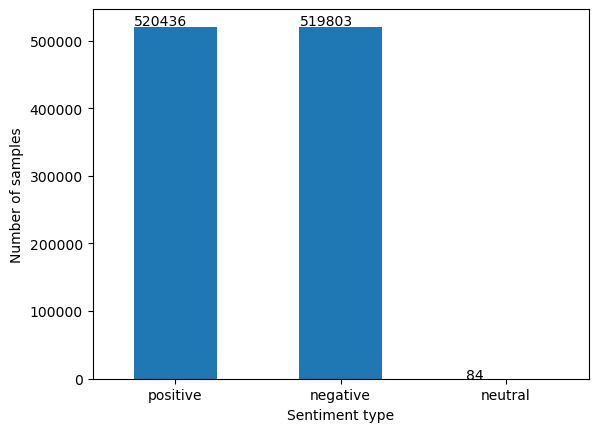

In [48]:
counts = df["target"].value_counts()
ax = counts.plot(kind='bar')
plt.xlabel("Sentiment type")
plt.xticks(rotation=360)
plt.ylabel("Number of samples")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Pre-Process Train

#### Helper functions

In [7]:
class PreProc():
    def __init__(self):
        pass
        
    def remove_more_stop_words(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: self.word_counts[word] >50)
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #return low frequency words + words that don't appear in train
    def remove_more_stop_words_test(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: False if not word in self.word_counts else (True if self.word_counts[word] >50 else False))
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #find the correct wordnet tag for nltk pos_tag equivalent  
    def get_wordnet_pos(self,treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    #lemmatize 
    def lemmatize(self,word_list):
        pos_tag = nltk.pos_tag(list(word_list))
        words = [self.lemmatizer.lemmatize(i[0], self.get_wordnet_pos(i[1])) for i in pos_tag]
        return words    
        
    def preproc(self,df, is_test=False):
    
        feature_df = df.copy()
        #convert lower case
        feature_df['text'] = feature_df['text'].str.lower()
        #remove URLS
        feature_df['text'] = feature_df['text'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', regex=True)
        #remove mentions
        feature_df['text'] = feature_df['text'].str.replace(r'@([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove hashtags
        feature_df['text'] = feature_df['text'].str.replace(r'#([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove punctuations
        feature_df['text'] = feature_df['text'].str.replace(r'[^\w\s]', '', regex=True)
        #tokenize
        feature_df['text'] = feature_df['text'].apply(lambda x : np.asarray(list(tokenize(x))))

        if not is_test:
            #encode target labels 
            label_encoder = LabelEncoder()
            label_encoder.fit(feature_df['target'])
            feature_df['target'] = label_encoder.transform(feature_df['target'])
            #check word counts
            self.word_counts = feature_df.explode('text')['text'].value_counts().to_dict()
            #remove low frequency words
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words)

        elif is_test:
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words_test)

        #lemmatize
        self.lemmatizer = WordNetLemmatizer()
        feature_df['text'] = feature_df['text'].apply(self.lemmatize)

        if not is_test:
            #vocab
            vocabulary = feature_df.explode('text')['text'].value_counts().to_dict()
            #vocab length
            vocab_length = len(vocabulary)
            return feature_df, self.word_counts, vocabulary, vocab_length

        elif is_test:
            return feature_df
            
    

In [2]:
#word2vec train and fit function
def create_embedding(df):
    sentence_list = [row for row in feature_df['text']]
    w2v = Word2Vec(sample=3e-5, min_count=1, sg=0)
    w2v.build_vocab(corpus_iterable=sentence_list)
    w2v.train(corpus_iterable=sentence_list, total_examples=w2v.corpus_count, epochs=100, report_delay=1)
    key_index = w2v.wv.key_to_index
    # MAKE A DICT
    word_dict = {word:w2v.wv[word] for word in key_index}
    
    embedding_weights = w2v.wv.vectors
    #add zeros vector to align indices of keras and gensim tokenizer
    row_zero = np.zeros((100))
    embedding_weights = np.insert(embedding_weights, 0, row_zero, axis=0)
    return word_dict, embedding_weights

In [11]:
def to_sequences(train_df, test_df):

    #list of input sentences
    X = train_df['text'].values

    #array of 0,1 and 2 labels
    Y = train_df['target'].to_numpy()
    input_tokenizer = Tokenizer()
    input_tokenizer.fit_on_texts(X)
    encoded_X = input_tokenizer.texts_to_sequences(X)
    
    # right pad for equal length 
    X_train = pad_sequences(encoded_X, maxlen=50, padding='post')
    
    #generate train-val set
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y, stratify=Y, test_size=0.2, random_state=40)
    
    #test sequences
    X_test = test_df['text'].values
    x_test_sequences = input_tokenizer.texts_to_sequences(X_test)
    x_test = pad_sequences(x_test_sequences, maxlen=50, padding='post')
    return x_train, x_val, x_test, y_train, y_val

In [12]:
def get_predictions(x, model, checkpoint_path):
    model.load_weights(checkpoint_path)
    predictions = model.predict(x)
    return predictions

In [13]:
def plot_cf(Y_true, Y_pred):
    cf = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,8))
    sb.heatmap(cf, annot=True, fmt="d", cmap='Blues')
    return None

## Pre-Process data and save dataframe

In [ ]:
preprocess = PreProc()
feature_df, word_counts, vocabulary, vocab_length = preprocess.preproc(df, is_test=False)
feature_df_test = preprocess.preproc(test_df, is_test=True)

In [4]:
path_df_LSTM_train = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_LSTM.pkl'
path_df_LSTM_test = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_test_LSTM.pkl'

In [5]:
#feature_df.to_pickle(path_df_LSTM_train)
#feature_df_test.to_pickle(path_df_LSTM_test)

In [6]:
#Uncomment and load dataframe if already pro-processed and saved
feature_df = pd.read_pickle(path_df_LSTM_train)
feature_df_test = pd.read_pickle(path_df_LSTM_test)

In [58]:
feature_df

,id,text,target
0,0,"[anyway, im, get, of, for, a, while]",2
1,1,"[my, red, isnt, feelin, too, well, this, morning]",0
2,2,"[you, should, be, it, great, friday, will, be,...",2
3,3,"[it, pm, and, i, dont, wanna, sleep, so, i, wi...",2
4,4,"[why, do, twitter, eat, my, dm, not, happy]",0
...,...,...,...
1040318,1040318,"[get, ready, watch, mental]",2
1040319,1040319,"[and, half, be, on, free, movie, on, demand, t...",0
1040320,1040320,"[go, out, in, make, me, jealous, of, you, im, ...",0
1040321,1040321,"[lol, u, look, sooo, much, like, that, vampire...",2


## Create Word2Vec Embedding

In [ ]:
word_dict, embedding_weights = create_embedding(feature_df)

In [ ]:
embedding_weights.shape

In [7]:
path_word_dict = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\word_dict.pkl'
path_embedding_weights = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\Word2Vec_weights.pkl'

In [18]:
with open(path_word_dict, 'wb') as f:
        pickle.dump(word_dict, f)
with open(path_embedding_weights, 'wb') as f:
        pickle.dump(embedding_weights, f)

In [8]:
word_dict = pickle.load( open(path_word_dict, 'rb'))
embedding_weights =pickle.load(open(path_embedding_weights, 'rb'))

## Create train-val and test sets

In [14]:
x_train, x_val, x_test, y_train, y_val = to_sequences(feature_df, feature_df_test)

## Model LSTM

In [15]:
def create_model_1():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    model.add(Conv1D(128, kernel_size=1, padding='valid', activation='relu'))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_1 = create_model_1()

In [16]:
checkpoint_filepath_model_1_LSTM = 'Models/checkpoint_model_1_1_LSTM/cp.ckpt'
model_checkpoint_callback_model_1_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_1_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
lstm_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           905600    
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           12928     
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                        

In [16]:
def create_model_2():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    model.add(Conv1D(128, kernel_size=2, padding='valid', activation='relu'))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_2 = create_model_2()

In [17]:
checkpoint_filepath_model_2_BiLSTM = 'Models/checkpoint_model_2_1_BiLSTM/cp.ckpt'
model_checkpoint_callback_model_2_BiLSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_2_BiLSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [26]:
lstm_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           905600    
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 128)           25728     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 49, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 49, 128)           131584    
                                                                 
 lstm_4 (LSTM)               (None, 49, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                      

In [18]:
def create_model_3():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    model.add(Conv1D(128, kernel_size=3, padding='valid', activation='relu'))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_3 = create_model_3()

In [19]:
checkpoint_filepath_model_3_C_LSTM = 'Models/checkpoint_model_3_1_C_LSTM/cp.ckpt'
model_checkpoint_callback_model_3_C_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_3_C_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
lstm_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           905600    
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 128)           38528     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 48, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 48, 128)           131584    
                                                                 
 lstm_7 (LSTM)               (None, 48, 128)           131584    
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                      

In [20]:
def create_model_4():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    model.add(Conv1D(128, kernel_size=4, padding='valid', activation='relu'))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(128, dropout=0.2, return_sequences=True))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_4 = create_model_4()

In [21]:
checkpoint_filepath_model_4_C_LSTM = 'Models/checkpoint_model_4_1_C_LSTM/cp.ckpt'
model_checkpoint_callback_model_4_C_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_4_C_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
def train(x, y, model, optimizer, loss, checkpoint, metrics, batch_size, epochs, validation_data):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(
        x,
        y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        shuffle=True,
        callbacks=[checkpoint]
    )
    return history

In [19]:
model_metrics_1 = train(x_train, y_train, model=lstm_model_1,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint=model_checkpoint_callback_model_1_LSTM ,metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 25s 26ms/step - loss: 0.5281 - accuracy: 0.7308 - val_loss: 0.4746 - val_accuracy: 0.7712
Epoch 2/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4787 - accuracy: 0.7693 - val_loss: 0.4574 - val_accuracy: 0.7821
Epoch 3/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4637 - accuracy: 0.7793 - val_loss: 0.4448 - val_accuracy: 0.7909
Epoch 4/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4534 - accuracy: 0.7857 - val_loss: 0.4382 - val_accuracy: 0.7943
Epoch 5/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4468 - accuracy: 0.7897 - val_loss: 0.4314 - val_accuracy: 0.7986
Epoch 6/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4419 - accuracy: 0.7927 - val_loss: 0.4287 - val_accuracy: 0.7999
Epoch 7/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4371 - accuracy: 0.7955 - val_loss: 0.4238 - val_accuracy:

In [30]:
model_metrics_2 = train(x_train, y_train, model=lstm_model_2,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint= model_checkpoint_callback_model_2_BiLSTM, metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 26s 26ms/step - loss: 0.5388 - accuracy: 0.7164 - val_loss: 0.4732 - val_accuracy: 0.7728
Epoch 2/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4744 - accuracy: 0.7719 - val_loss: 0.4535 - val_accuracy: 0.7847
Epoch 3/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4603 - accuracy: 0.7814 - val_loss: 0.4434 - val_accuracy: 0.7906
Epoch 4/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4513 - accuracy: 0.7871 - val_loss: 0.4346 - val_accuracy: 0.7970
Epoch 5/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4444 - accuracy: 0.7915 - val_loss: 0.4332 - val_accuracy: 0.7974
Epoch 6/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4398 - accuracy: 0.7938 - val_loss: 0.4254 - val_accuracy: 0.8019
Epoch 7/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4352 - accuracy: 0.7963 - val_loss: 0.4230 - val_accuracy:

In [31]:
model_metrics_3 = train(x_train, y_train, model=lstm_model_3,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint= model_checkpoint_callback_model_3_C_LSTM, metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 23s 26ms/step - loss: 0.5374 - accuracy: 0.7199 - val_loss: 0.4751 - val_accuracy: 0.7691
Epoch 2/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4740 - accuracy: 0.7722 - val_loss: 0.4542 - val_accuracy: 0.7857
Epoch 3/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4588 - accuracy: 0.7820 - val_loss: 0.4470 - val_accuracy: 0.7879
Epoch 4/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4494 - accuracy: 0.7878 - val_loss: 0.4393 - val_accuracy: 0.7948
Epoch 5/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4434 - accuracy: 0.7914 - val_loss: 0.4373 - val_accuracy: 0.7965
Epoch 6/50
813/813 [==============================] - 21s 25ms/step - loss: 0.4379 - accuracy: 0.7951 - val_loss: 0.4264 - val_accuracy: 0.8010
Epoch 7/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4337 - accuracy: 0.7976 - val_loss: 0.4231 - val_accuracy:

In [32]:
model_metrics_4 = train(x_train, y_train, model=lstm_model_4,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint=model_checkpoint_callback_model_4_C_LSTM ,metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 24s 27ms/step - loss: 0.5309 - accuracy: 0.7289 - val_loss: 0.4816 - val_accuracy: 0.7684
Epoch 2/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4774 - accuracy: 0.7702 - val_loss: 0.4565 - val_accuracy: 0.7826
Epoch 3/50
813/813 [==============================] - 21s 26ms/step - loss: 0.4624 - accuracy: 0.7797 - val_loss: 0.4466 - val_accuracy: 0.7886
Epoch 4/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4531 - accuracy: 0.7858 - val_loss: 0.4413 - val_accuracy: 0.7906
Epoch 5/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4464 - accuracy: 0.7897 - val_loss: 0.4343 - val_accuracy: 0.7964
Epoch 6/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4409 - accuracy: 0.7928 - val_loss: 0.4324 - val_accuracy: 0.7986
Epoch 7/50
813/813 [==============================] - 20s 25ms/step - loss: 0.4368 - accuracy: 0.7956 - val_loss: 0.4277 - val_accuracy:

#### Results

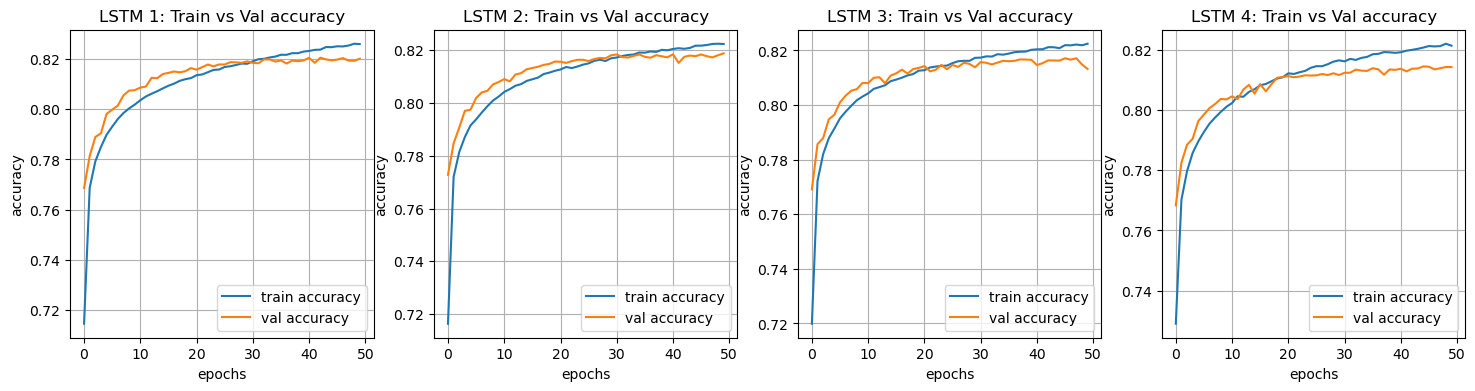

In [47]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.plot(model_metrics_1.history["accuracy"])
plt.plot(model_metrics_1.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("LSTM 1: Train vs Val accuracy")
plt.legend(["train accuracy","val accuracy"])
plt.grid()


plt.subplot(1, 4, 2)
plt.plot(model_metrics_2.history["accuracy"])
plt.plot(model_metrics_2.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("LSTM 2: Train vs Val accuracy")
plt.legend(["train accuracy","val accuracy"])
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(model_metrics_3.history["accuracy"])
plt.plot(model_metrics_3.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("LSTM 3: Train vs Val accuracy")
plt.legend(["train accuracy","val accuracy"])
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(model_metrics_4.history["accuracy"])
plt.plot(model_metrics_4.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("LSTM 4: Train vs Val accuracy")
plt.legend(["train accuracy","val accuracy"])
plt.grid()

plt.show()

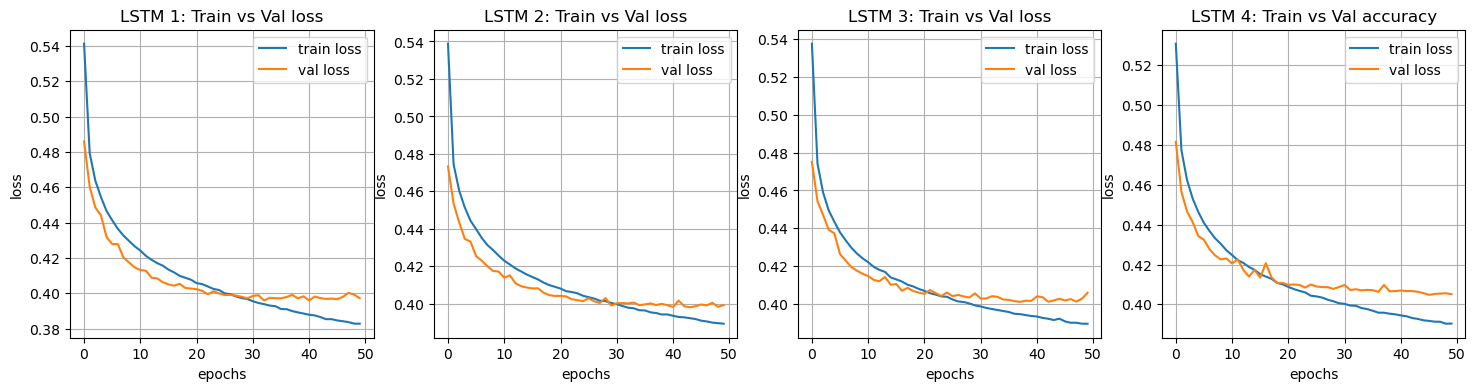

In [48]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.plot(model_metrics_1.history["loss"])
plt.plot(model_metrics_1.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM 1: Train vs Val loss")
plt.legend(["train loss","val loss"])
plt.grid()


plt.subplot(1, 4, 2)
plt.plot(model_metrics_2.history["loss"])
plt.plot(model_metrics_2.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM 2: Train vs Val loss")
plt.legend(["train loss","val loss"])
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(model_metrics_3.history["loss"])
plt.plot(model_metrics_3.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM 3: Train vs Val loss")
plt.legend(["train loss","val loss"])
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(model_metrics_4.history["loss"])
plt.plot(model_metrics_4.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM 4: Train vs Val accuracy")
plt.legend(["train loss","val loss"])
plt.grid()

plt.show()

#### BiLSTM

In [20]:
def create_model_5():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    
    model.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=False)))
    
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_5 = create_model_5()

In [21]:
checkpoint_filepath_model_5_C_LSTM = 'Models/checkpoint_model_5_1_C_LSTM/cp.ckpt'
model_checkpoint_callback_model_5_C_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_5_C_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
model_metrics_5 = train(x_train, y_train, model=lstm_model_5,optimizer='adam',checkpoint=model_checkpoint_callback_model_5_C_LSTM, loss='sparse_categorical_crossentropy' ,metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 14s 16ms/step - loss: 0.5131 - accuracy: 0.7462 - val_loss: 0.4684 - val_accuracy: 0.7756
Epoch 2/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4679 - accuracy: 0.7755 - val_loss: 0.4454 - val_accuracy: 0.7894
Epoch 3/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4504 - accuracy: 0.7867 - val_loss: 0.4340 - val_accuracy: 0.7969
Epoch 4/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4398 - accuracy: 0.7929 - val_loss: 0.4319 - val_accuracy: 0.7997
Epoch 5/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4321 - accuracy: 0.7982 - val_loss: 0.4242 - val_accuracy: 0.8031
Epoch 6/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4258 - accuracy: 0.8016 - val_loss: 0.4209 - val_accuracy: 0.8060
Epoch 7/50
813/813 [==============================] - 12s 15ms/step - loss: 0.4210 - accuracy: 0.8044 - val_loss: 0.4186 - val_accuracy:

In [23]:
def create_model_6():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    
    model.add(LSTM(128, dropout=0.2, return_sequences=False))
    
    model.add(Dense(3,activation='softmax'))
    return model

lstm_model_6 = create_model_6()

In [24]:
checkpoint_filepath_model_6_C_LSTM = 'Models/checkpoint_model_6_1_C_LSTM/cp.ckpt'
model_checkpoint_callback_model_6_C_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_model_6_C_LSTM,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [25]:
model_metrics_6 = train(x_train, y_train, model=lstm_model_6,optimizer='adam',checkpoint=model_checkpoint_callback_model_6_C_LSTM, loss='sparse_categorical_crossentropy' ,metrics=['accuracy'], batch_size=1024, epochs=50, validation_data=(x_val,y_val))

Epoch 1/50
813/813 [==============================] - 8s 9ms/step - loss: 0.5237 - accuracy: 0.7355 - val_loss: 0.4723 - val_accuracy: 0.7740
Epoch 2/50
813/813 [==============================] - 7s 9ms/step - loss: 0.4714 - accuracy: 0.7738 - val_loss: 0.4493 - val_accuracy: 0.7873
Epoch 3/50
813/813 [==============================] - 7s 9ms/step - loss: 0.4560 - accuracy: 0.7832 - val_loss: 0.4440 - val_accuracy: 0.7908
Epoch 4/50
813/813 [==============================] - 7s 8ms/step - loss: 0.4452 - accuracy: 0.7901 - val_loss: 0.4356 - val_accuracy: 0.7949
Epoch 5/50
813/813 [==============================] - 7s 8ms/step - loss: 0.4376 - accuracy: 0.7948 - val_loss: 0.4265 - val_accuracy: 0.8020
Epoch 6/50
813/813 [==============================] - 7s 9ms/step - loss: 0.4318 - accuracy: 0.7979 - val_loss: 0.4228 - val_accuracy: 0.8047
Epoch 7/50
813/813 [==============================] - 7s 9ms/step - loss: 0.4265 - accuracy: 0.8011 - val_loss: 0.4189 - val_accuracy: 0.8071
Epoch 

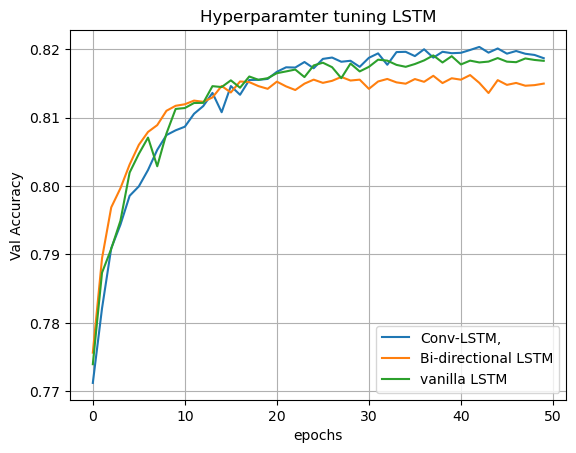

In [26]:
plt.plot(model_metrics_1.history["val_accuracy"])
plt.plot(model_metrics_5.history["val_accuracy"])
plt.plot(model_metrics_6.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("Val Accuracy")
plt.title("Hyperparamter tuning LSTM")
plt.legend(["Conv-LSTM,","Bi-directional LSTM","vanilla LSTM"])
plt.grid()


### Final train on whole set

In [53]:
new_x = np.concatenate((x_train,x_val),axis=0)
new_y = np.concatenate((y_train,y_val),axis=0)

In [54]:
new_x.shape

(1040323, 50)

In [ ]:
model_metrics_1 = train(new_x, new_y, model=lstm_model_1,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint=model_checkpoint_callback_model_1_LSTM ,metrics=['accuracy'], batch_size=1024, epochs=20, validation_data=(x_val,y_val))

In [56]:
model_metrics_2 = train(new_x, new_y, model=lstm_model_2,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint= model_checkpoint_callback_model_2_BiLSTM, metrics=['accuracy'], batch_size=1024, epochs=20, validation_data=(x_val,y_val))

Epoch 1/20
1016/1016 [==============================] - 29s 26ms/step - loss: 0.3967 - accuracy: 0.8182 - val_loss: 0.3911 - val_accuracy: 0.8222
Epoch 2/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3955 - accuracy: 0.8194 - val_loss: 0.3880 - val_accuracy: 0.8240
Epoch 3/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3945 - accuracy: 0.8197 - val_loss: 0.3848 - val_accuracy: 0.8258
Epoch 4/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3946 - accuracy: 0.8196 - val_loss: 0.3825 - val_accuracy: 0.8269
Epoch 5/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3939 - accuracy: 0.8200 - val_loss: 0.3812 - val_accuracy: 0.8274
Epoch 6/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3932 - accuracy: 0.8202 - val_loss: 0.3800 - val_accuracy: 0.8276
Epoch 7/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3928 - accuracy: 0.8207 - val_loss: 0.3777 -

In [57]:
model_metrics_3 = train(new_x, new_y, model=lstm_model_3,optimizer='adam', loss='sparse_categorical_crossentropy', checkpoint= model_checkpoint_callback_model_3_C_LSTM, metrics=['accuracy'], batch_size=1024, epochs=20, validation_data=(x_val,y_val))

Epoch 1/20
1016/1016 [==============================] - 29s 26ms/step - loss: 0.3988 - accuracy: 0.8177 - val_loss: 0.3941 - val_accuracy: 0.8203
Epoch 2/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3978 - accuracy: 0.8180 - val_loss: 0.3898 - val_accuracy: 0.8233
Epoch 3/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3974 - accuracy: 0.8181 - val_loss: 0.3871 - val_accuracy: 0.8238
Epoch 4/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3965 - accuracy: 0.8183 - val_loss: 0.3851 - val_accuracy: 0.8248
Epoch 5/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3960 - accuracy: 0.8189 - val_loss: 0.3830 - val_accuracy: 0.8262
Epoch 6/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3958 - accuracy: 0.8190 - val_loss: 0.3828 - val_accuracy: 0.8264
Epoch 7/20
1016/1016 [==============================] - 25s 25ms/step - loss: 0.3951 - accuracy: 0.8195 - val_loss: 0.3803 -

In [58]:
model_metrics_4 = train(new_x, new_y, model=lstm_model_4,optimizer='nadam', loss='sparse_categorical_crossentropy', checkpoint=model_checkpoint_callback_model_4_C_LSTM ,metrics=['accuracy'], batch_size=1024, epochs=20, validation_data=(x_val,y_val))

Epoch 1/20
1016/1016 [==============================] - 34s 30ms/step - loss: 0.4001 - accuracy: 0.8168 - val_loss: 0.3966 - val_accuracy: 0.8193
Epoch 2/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3994 - accuracy: 0.8169 - val_loss: 0.3932 - val_accuracy: 0.8207
Epoch 3/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3982 - accuracy: 0.8179 - val_loss: 0.3879 - val_accuracy: 0.8236
Epoch 4/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3977 - accuracy: 0.8178 - val_loss: 0.3853 - val_accuracy: 0.8250
Epoch 5/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3974 - accuracy: 0.8180 - val_loss: 0.3826 - val_accuracy: 0.8259
Epoch 6/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3965 - accuracy: 0.8186 - val_loss: 0.3816 - val_accuracy: 0.8269
Epoch 7/20
1016/1016 [==============================] - 30s 30ms/step - loss: 0.3960 - accuracy: 0.8190 - val_loss: 0.3786 -

### Validation

In [50]:
y_proba_val_1 = get_predictions(x_val, lstm_model_1, checkpoint_filepath_model_1_LSTM)
y_proba_val_2 = get_predictions(x_val, lstm_model_2, checkpoint_filepath_model_2_BiLSTM)
y_proba_val_3 = get_predictions(x_val, lstm_model_3, checkpoint_filepath_model_3_C_LSTM)
y_proba_val_4 = get_predictions(x_val, lstm_model_4, checkpoint_filepath_model_4_C_LSTM)

6503/6503 [==============================] - 75s 11ms/step


In [51]:
y_proba_val_ensemble = y_proba_val_1 + y_proba_val_2 + y_proba_val_3 + y_proba_val_4
y_pred_classes_val = np.argmax(y_proba_val_ensemble, axis=1)

In [52]:
print(accuracy_score(y_val, y_pred_classes_val))

0.825290173743782


In [53]:
print(classification_report(y_val, y_pred_classes_val))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    103961
           1       0.00      0.00      0.00        17
           2       0.82      0.83      0.83    104087

    accuracy                           0.83    208065
   macro avg       0.55      0.55      0.55    208065
weighted avg       0.83      0.83      0.83    208065



C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix for Ensemble of LSTMs ')

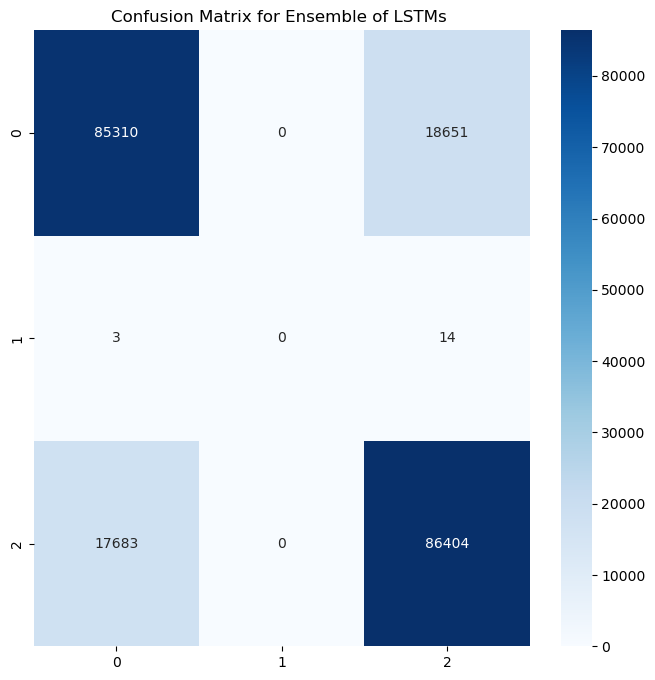

In [56]:
plot_cf(y_val, y_pred_classes_val)
plt.title("Confusion Matrix for Ensemble of LSTMs ")

## Test

In [59]:
y_proba_test_1 = get_predictions(x_test, lstm_model_1, checkpoint_filepath_model_1_LSTM)
y_proba_test_2 = get_predictions(x_test, lstm_model_2, checkpoint_filepath_model_2_BiLSTM)
y_proba_test_3 = get_predictions(x_test, lstm_model_3, checkpoint_filepath_model_3_C_LSTM)
y_proba_test_4 = get_predictions(x_test, lstm_model_4, checkpoint_filepath_model_4_C_LSTM)

17506/17506 [==============================] - 76s 4ms/step


In [60]:
y_proba_test_ensemble = y_proba_test_1 + y_proba_test_2 + y_proba_test_3
y_pred_classes_test = np.argmax(y_proba_test_ensemble, axis=1)

In [61]:
predictions_df = pd.DataFrame(y_pred_classes_test, columns=['target'])
predictions_df.index.name = 'id'

In [62]:
predictions_df

,target
id,
0,0
1,2
2,0
3,0
4,0
...,...
560170,0
560171,0
560172,0


In [ ]:
path_output = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Test_output\\test_results_LSTM_full.csv'

In [64]:
predictions_df.to_csv(path_output, index=True, index_label='id')

<AxesSubplot:ylabel='Count'>

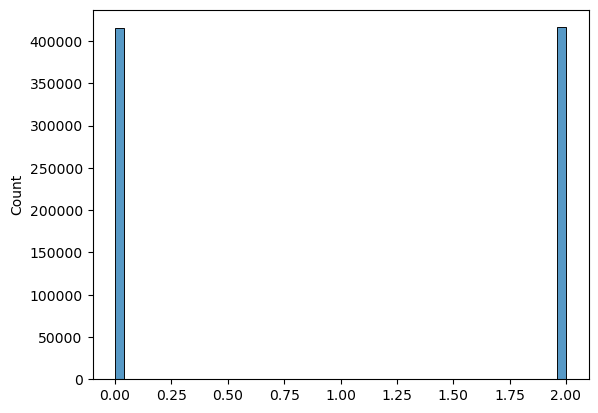

### References

- https://arxiv.org/pdf/1310.4546.pdf
- https://stackoverflow.com/questions/34721984/stopword-removing-when-using-the-word2vec
- https://radimrehurek.com/gensim/models/word2vec.html